# Import and Installing packages

In [ ]:
!pip install opencv-python

^C


In [ ]:
import os
import json
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms.functional as F
from torch.utils.data import Dataset, DataLoader, ConcatDataset, Subset, random_split
from PIL import Image
import time
import matplotlib.pyplot as plt
import cv2
from torchvision import transforms
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import f1_score
from sklearn.model_selection import KFold
import math

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch

# Release all unoccupied cached memory
torch.cuda.empty_cache()

print("CUDA cached memory released.")


CUDA cached memory released.


# Model Construction

# Simple UNet

In [ ]:
class SimpleUNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=3, base_channels=32, dropout_rate=0.3):
        super(SimpleUNet, self).__init__()
        self.dropout_rate = dropout_rate

        # Reduced number of channels and layers
        self.conv1 = self.conv_block(in_channels, base_channels)
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = self.conv_block(base_channels, base_channels*2)
        self.pool2 = nn.MaxPool2d(2)
        self.conv3 = self.conv_block(base_channels*2, base_channels*4)

        self.dropout = nn.Dropout2d(p=dropout_rate)

        self.up4 = nn.ConvTranspose2d(base_channels*4, base_channels*2, 2, stride=2)
        self.conv4 = self.conv_block(base_channels*4, base_channels*2)
        self.up5 = nn.ConvTranspose2d(base_channels*2, base_channels, 2, stride=2)
        self.conv5 = self.conv_block(base_channels*2, base_channels)
        self.conv6 = nn.Conv2d(base_channels, out_channels, 1)

    def forward(self, x):
        c1 = self.conv1(x)
        p1 = self.pool1(c1)
        p1 = self.dropout(p1)

        c2 = self.conv2(p1)
        p2 = self.pool2(c2)
        p2 = self.dropout(p2)

        c3 = self.conv3(p2)
        c3 = self.dropout(c3)

        up_4 = self.up4(c3)
        merge4 = torch.cat([up_4, c2], dim=1)
        c4 = self.conv4(merge4)

        up_5 = self.up5(c4)
        merge5 = torch.cat([up_5, c1], dim=1)
        c5 = self.conv5(merge5)

        c6 = self.conv6(c5)
        return c6

    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )



# UNet

In [ ]:
class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=3, dropout_rate=0.4):
        super(UNet, self).__init__()
        self.dropout_rate = dropout_rate

        self.conv1 = self.conv_block(in_channels, 64)
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = self.conv_block(64, 128)
        self.pool2 = nn.MaxPool2d(2)
        self.conv3 = self.conv_block(128, 256)
        self.pool3 = nn.MaxPool2d(2)
        self.conv4 = self.conv_block(256, 512)
        self.pool4 = nn.MaxPool2d(2)
        self.conv5 = self.conv_block(512, 1024)

        self.dropout = nn.Dropout2d(p=dropout_rate)

        self.up6 = nn.ConvTranspose2d(1024, 512, 2, stride=2)
        self.conv6 = self.conv_block(1024, 512)
        self.up7 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.conv7 = self.conv_block(512, 256)
        self.up8 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.conv8 = self.conv_block(256, 128)
        self.up9 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.conv9 = self.conv_block(128, 64)
        self.conv10 = nn.Conv2d(64, out_channels, 1)

    def forward(self, x):
        c1 = self.conv1(x)
        p1 = self.pool1(c1)
        p1 = self.dropout(p1)

        c2 = self.conv2(p1)
        p2 = self.pool2(c2)
        p2 = self.dropout(p2)

        c3 = self.conv3(p2)
        p3 = self.pool3(c3)
        p3 = self.dropout(p3)

        c4 = self.conv4(p3)
        p4 = self.pool4(c4)
        p4 = self.dropout(p4)

        c5 = self.conv5(p4)
        c5 = self.dropout(c5)

        up_6 = self.up6(c5)
        merge6 = torch.cat([up_6, c4], dim=1)
        c6 = self.conv6(merge6)

        up_7 = self.up7(c6)
        merge7 = torch.cat([up_7, c3], dim=1)
        c7 = self.conv7(merge7)

        up_8 = self.up8(c7)
        merge8 = torch.cat([up_8, c2], dim=1)
        c8 = self.conv8(merge8)

        up_9 = self.up9(c8)
        merge9 = torch.cat([up_9, c1], dim=1)
        c9 = self.conv9(merge9)

        c10 = self.conv10(c9)
        return c10

    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.ReLU(inplace=True)
        )

# Evaluation metrics functions

In [ ]:
def calculate_iou(preds, masks, threshold = 0.5 smooth=1e-6):
    # First, apply threshold to predictions
    preds_binary = (preds >= threshold).float()
    masks_binary = (masks >= threshold).float()

    intersection = ((preds_binary == masks_binary) & (masks_binary == 1)).float().sum()
    union = ((preds_binary == 1) | (masks_binary == 1)).float().sum()
    iou = (intersection + smooth) / (union + smooth)
    return iou


def dice_coefficient(preds, targets, smooth=1e-6):

    intersection = (preds * targets).sum()
    dice = (2 * intersection + smooth) / (preds.sum() + targets.sum() + smooth)

    return dice

def save_predictions(model, dataloader, device, output_base_dir="/content/drive/MyDrive/output_unet_complex/prediction_images"):


    os.makedirs(output_base_dir, exist_ok=True)
    model.eval()
    with torch.no_grad():
        for i, (inputs, masks) in enumerate(dataloader):
            inputs = inputs.to(device)
            masks = masks.to(device)
            outputs = torch.sigmoid(model(inputs))
            preds = (outputs > 0.5).float()

            for j in range(inputs.size(0)):
                pred_img = preds[j].permute(1, 2, 0).cpu().numpy() * 255
                mask_img = masks[j].permute(1, 2, 0).cpu().numpy() * 255

                pred_path = os.path.join(output_base_dir, f"prediction_{i * inputs.size(0) + j}.png")
                mask_path = os.path.join(output_base_dir, f"mask_{i * inputs.size(0) + j}.png")

                cv2.imwrite(pred_path, pred_img)
                cv2.imwrite(mask_path, mask_img)



def plot_metrics(metrics, output_base_dir='/content/drive/MyDrive/output_unet_complex/'):

    os.makedirs(output_base_dir, exist_ok=True)
    epochs = range(1, len(metrics['train_loss']) + 1)
    plt_params = [
        ('Loss', ['train_loss', 'val_loss']),
        ('Accuracy', ['train_accuracy', 'val_accuracy']),
        ('Dice', ['train_dice', 'val_dice']),
        ('IoU', ['train_iou', 'val_iou'])
    ]

    for title, metric_keys in plt_params:
        plt.figure(figsize=(10, 6))
        plt.plot(epochs, [torch.tensor(x).item() for x in metrics[metric_keys[0]]], label=f"Train {title}")
        plt.plot(epochs, [torch.tensor(x).item() for x in metrics[metric_keys[1]]], label=f"Validation {title}")
        plt.xlabel("Epochs")
        plt.ylabel(title)
        plt.title(f'{title} vs Epochs ')
        plt.legend()
        plt.savefig(os.path.join(output_base_dir, f'{title}.png'))
        plt.show()
        plt.close()

def get_metrics_summary(metrics):

    metrics_summary = {
        'avg_train_loss': sum(metrics['train_loss']) / len(metrics['train_loss']),
        'avg_val_loss': sum(metrics['val_loss']) / len(metrics['val_loss']),

        'avg_train_accuracy': sum(metrics['train_accuracy']) / len(metrics['train_accuracy']),
        'avg_val_accuracy': sum(metrics['val_accuracy']) / len(metrics['val_accuracy']),

        'avg_train_dice': sum(metrics['train_dice']) / len(metrics['train_dice']),
        'avg_val_dice': sum(metrics['val_dice']) / len(metrics['val_dice']),

        'avg_train_iou': sum(metrics['train_iou']) / len(metrics['train_iou']),
        'avg_val_iou': sum(metrics['val_iou']) / len(metrics['val_iou'])
    }

    return metrics_summary


# Model Training

In [ ]:
def train_with_metrics(model, train_loader, val_loader, device, num_epochs, lr, save_path='/content/drive/MyDrive/output_unet_complex/modelunetcomplextrained'):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.BCEWithLogitsLoss()  # Multi-channel binary classification
    metrics = {"train_loss": [], "val_loss": [], "train_accuracy": [],
               "val_accuracy": [], "train_dice": [], "val_dice": [],
               "train_iou": [], "val_iou": []}
    best_val_loss = float('inf')
    print("Initiating training in epochs...")
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        train_correct = 0
        train_total = 0
        train_dice = 0
        train_iou = 0

        for inputs, masks in train_loader:
            inputs = inputs.to(device)
            masks = masks.to(device).float()
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            preds = torch.sigmoid(outputs) > 0.5
            train_correct += (preds == masks).sum().item()
            train_total += masks.numel()
            train_dice += dice_coefficient(preds,masks)
            train_iou += calculate_iou(preds, masks, threshold=0.5)

        train_loss /= len(train_loader)
        train_accuracy = 100 * train_correct / train_total
        train_dice /= len(train_loader)
        train_iou /= len(train_loader)


        model.eval()
        val_loss = 0
        val_correct = 0
        val_total = 0
        val_dice = 0
        val_iou = 0

        with torch.no_grad():
            for inputs, masks in val_loader:
                inputs = inputs.to(device)
                masks = masks.to(device).float()
                outputs = model(inputs)
                loss = criterion(outputs, masks)
                val_loss += loss.item()
                preds = torch.sigmoid(outputs) > 0.5
                val_correct += (preds == masks).sum().item()
                val_total += masks.numel()
                val_dice += dice_coefficient(preds,masks)
                val_iou += calculate_iou(preds, masks, threshold=0.5)


        val_loss /= len(val_loader)
        val_accuracy = 100 * val_correct / val_total
        val_dice /= len(val_loader)
        val_iou /= len(val_loader)


        metrics["train_loss"].append(train_loss)
        metrics["val_loss"].append(val_loss)
        metrics["train_accuracy"].append(train_accuracy)
        metrics["val_accuracy"].append(val_accuracy)
        metrics["train_dice"].append(train_dice)
        metrics["val_dice"].append(val_dice)
        metrics["train_iou"].append(train_iou)
        metrics["val_iou"].append(val_iou)


        print(f"Epoch [{epoch+1}/{num_epochs}], "
              f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, "
              f"Train Dice: {train_dice:.4f}, Train IoU: {train_iou:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%, "
              f"Val Dice: {val_dice:.4f}, Val IoU: {val_iou:.4f} ")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            print("Validation loss improved, saving the model...")

            torch.save(model.state_dict(), f"{save_path}_weights.pth")
            torch.save(model, f"{save_path}_model.pth")

    metrics_summary = get_metrics_summary(metrics)

    print("\nMetrics Summary:")
    for metric, value in metrics_summary.items():
        print(f"{metric}: {value:.4f}")

    return metrics, metrics_summary



# Data preprocessing and transformation

In [ ]:
def visualize_dataset_samples(dataset, output_dir='/content/drive/MyDrive/output_unet_complex/dataset_samples'):
    os.makedirs(output_dir, exist_ok=True)
    input_sample , mask_sample = dataset[0]
    # print(input_sample)
    # print(mask_sample)
    # Iterate through first few items
    for i in range(len(dataset)):
        input_tensor, mask_tensor = dataset[i]

        # Convert tensors to numpy for visualization
        # Assuming input_tensor is [2, H, W] and mask_tensor is [H, W]
        # print(input_tensor.shape)
        # print(mask_tensor.shape)

        # For input (assuming 2 channel input of PML and nuclei)
        plt.figure(figsize=(15, 7))  # Wider size for better side-by-side placement

        # Plot the input image
        plt.subplot(1, 2, 1)  # 1 row, 2 columns, first subplot
        plt.title(f'Input image (Sample {i})')
        input_tensor = input_tensor.permute(1, 2, 0)  # Convert from CxHxW to HxWxC for plotting
        plt.imshow(input_tensor.numpy())  # Show the input image
        plt.axis('off')  # Hide the axes

        # Plot the mask
        plt.subplot(1, 2, 2)  # 1 row, 2 columns, second subplot
        plt.title(f'Mask (Sample {i})')
        mask_tensor = mask_tensor.permute(1, 2, 0)  # Convert from CxHxW to HxWxC for plotting
        plt.imshow(mask_tensor.numpy())  # Show the mask
        plt.axis('off')  # Hide the axes

        # Adjust layout to prevent overlap
        plt.tight_layout()

        # Save the figure to the output directory
        plt.savefig(os.path.join(output_dir, f'dataset_sample_{i}.png'))

        # Show the plot
        #plt.show()
        plt.close()

class CustomTransform:
    def __init__(self, resize=(256, 256), mean=0.5, std=0.5):
        self.resize = resize
        self.mean = mean
        self.std = std

    def __call__(self, img):
        #print("In transform, image shape: ", img.shape)
        if not torch.is_tensor(img):
            img = torch.from_numpy(img).float()

        # Ensure the image has 3 channels (if it is a 3-channel RGB image)
        if img.dim() == 3 and img.shape[0] != 3:
            img = img.permute(2, 0, 1)  # Convert from HWC to CHW format if it's in HWC format

        # Resize image while keeping the 3 channels intact
        if img.shape[-2:] != self.resize:
            img = transforms.Resize(self.resize)(img)

        # Normalize the image
        if img.dim() == 3:  # Multiple channels (RGB)
            for t in range(3):
                img[t] = (img[t] - self.mean) / self.std
        else:  # Single channel (grayscale)
            img = (img - self.mean) / self.std

        #print("Transformed Input size: ", img.shape)
        return img




class AnnotatedSegmentationDataset(Dataset):
    def __init__(self, pml_dir, nuclei_dir, mask_dir, transform=None):
        self.pml_images = sorted([os.path.join(pml_dir, f) for f in os.listdir(pml_dir)
                                   if f.lower().endswith(('.tif', '.png', '.jpg', '.jpeg'))])
        self.nuclei_images = sorted([os.path.join(nuclei_dir, f) for f in os.listdir(nuclei_dir)
                                      if f.lower().endswith(('.tif', '.png', '.jpg', '.jpeg'))])
        self.mask_images = sorted([os.path.join(mask_dir, f) for f in os.listdir(mask_dir)
                                    if f.lower().endswith(('.tif', '.png', '.jpg', '.jpeg'))])

        assert len(self.pml_images) == len(self.nuclei_images) == len(self.mask_images), \
            "Number of images in different directories must be the same"

        self.transform = transform or CustomTransform()

    def __len__(self):
        return len(self.pml_images)

    def __getitem__(self, idx):
        pml_image = Image.open(self.pml_images[idx])
        nuclei_image = Image.open(self.nuclei_images[idx]).convert("RGB")
        mask_image = Image.open(self.mask_images[idx])
        transform_image = transforms.ToTensor()
        pml = transform_image(pml_image)
        nuclei_rgb = transform_image(nuclei_image)

        pml_array = np.array(pml_image)
        nuclei_array = np.array(nuclei_image)

        input_image = Image.blend(pml_image, nuclei_image, alpha=0.2)
        input_array = np.array(input_image)
        mask_array = np.array(mask_image)

        input_tensor = transform_image(input_array)
        transformed_input = self.transform(input_array)
        mask_tensor = transform_image(mask_array)
        transformed_mask = self.transform(mask_array)

        return input_tensor, mask_tensor






In [ ]:
def calculate_iou_for_testset(preds, masks, threshold=0.5, smooth=1e-6):

    preds_binary = (preds >= threshold).float()
    masks_binary = (masks >= threshold).float()

    intersection = ((preds_binary == masks_binary) & (masks_binary == 1)).float().sum()
    union = ((preds_binary == 1) | (masks_binary == 1)).float().sum()
    iou = (intersection + smooth) / (union + smooth)
    return iou

def calculate_iou_statistics(iou_values):
    filtered_ious = [iou for iou in iou_values if iou > 0 and isinstance(iou, (int, float))]

    if not filtered_ious:
        return {
            'avg_iou': 0,
            'std_dev': 0,
            'num_samples': 0,
            'min_iou': 0,
            'max_iou': 0
        }

    avg_iou = np.mean(filtered_ious)
    std_dev = np.std(filtered_ious)

    return {
        'avg_iou': avg_iou,
        'std_dev': std_dev,
        'num_samples': len(filtered_ious),
        'min_iou': min(filtered_ious),
        'max_iou': max(filtered_ious)
    }




def test_model(model, test_loader, device, output_dir="/content/drive/MyDrive/output_unet_complex/test_output"):

    os.makedirs(output_dir, exist_ok=True)
    model.eval()
    total_iou = 0
    num_samples = 0
    image_wise_iou = []

    with torch.no_grad():
        for i, (inputs, masks) in enumerate(test_loader):
            inputs = inputs.to(device)
            masks = masks.to(device)

            outputs = torch.sigmoid(model(inputs))
            preds = (outputs > 0.5).float()

            # Calculate IoU for each image in the batch
            for j in range(inputs.size(0)):
                single_pred = preds[j]
                single_mask = masks[j]
                single_iou = calculate_iou_for_testset(single_pred, single_mask, threshold=0.5)
                image_wise_iou.append(single_iou.item())

                # Save predictions and masks
                pred_img = single_pred.permute(1, 2, 0).cpu().numpy() * 255
                mask_img = single_mask.permute(1, 2, 0).cpu().numpy() * 255

                pred_path = os.path.join(output_dir, f"prediction_{i * inputs.size(0) + j}.png")
                mask_path = os.path.join(output_dir, f"mask_{i * inputs.size(0) + j}.png")

                cv2.imwrite(pred_path, pred_img)
                cv2.imwrite(mask_path, mask_img)

            # Calculate IoU for the batch
            batch_iou = calculate_iou_for_testset(preds, masks, threshold = 0.5)
            total_iou += batch_iou.item()
            num_samples += masks.size(0)

    stats = calculate_iou_statistics(image_wise_iou)
    print(stats)


    return stats


# Main Function


Total samples: 160
High arsenic samples: 80
No arsenic samples: 80
Dataset is ready..
Visualizing dataset samples
Total dataset size: 160
Train size: 112, Validation size: 24, Test size: 24
Data Loaded...
Initiating training in epochs...
Epoch [1/30], Train Loss: 2.7475, Train Accuracy: 80.30%, Train Dice: 0.9959, Train IoU: 0.1429, Val Loss: 0.6399, Val Accuracy: 87.37%, Val Dice: 1.0000, Val IoU: 0.0000 
Validation loss improved, saving the model...
Epoch [2/30], Train Loss: 0.6286, Train Accuracy: 77.89%, Train Dice: 0.8840, Train IoU: 0.0000, Val Loss: 0.5690, Val Accuracy: 58.48%, Val Dice: 0.9690, Val IoU: 0.0000 
Validation loss improved, saving the model...
Epoch [3/30], Train Loss: 0.2673, Train Accuracy: 80.90%, Train Dice: 0.9899, Train IoU: 0.6429, Val Loss: 0.0977, Val Accuracy: 87.37%, Val Dice: 1.0000, Val IoU: 1.0000 
Validation loss improved, saving the model...
Epoch [4/30], Train Loss: 0.0902, Train Accuracy: 86.39%, Train Dice: 1.0000, Train IoU: 1.0000, Val Loss: 

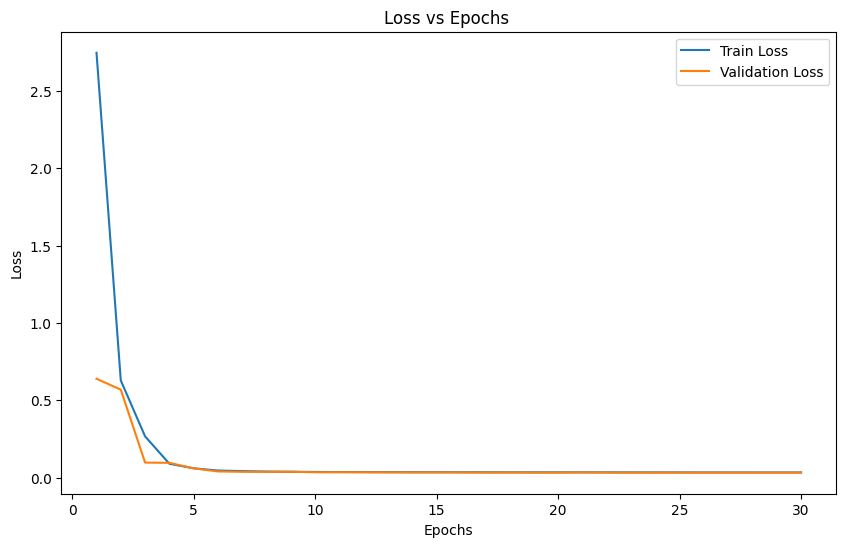

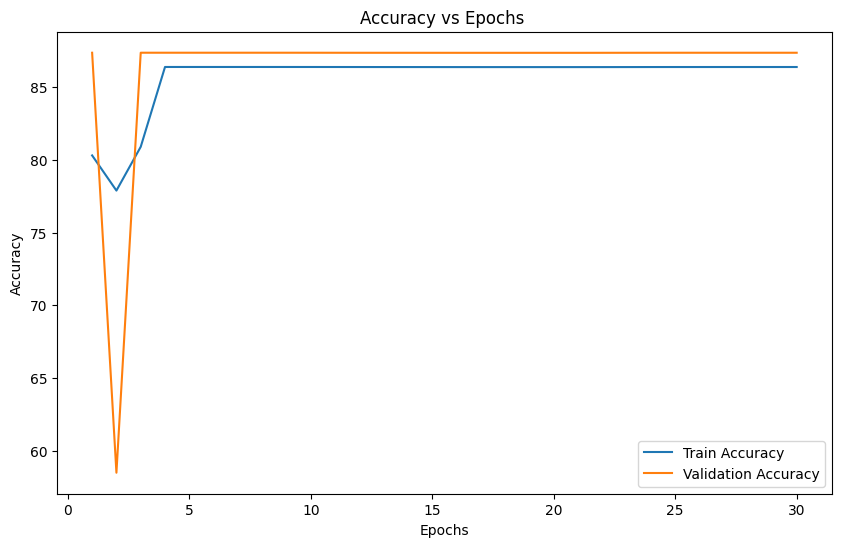

<ipython-input-5-08a115c1c17e>:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  plt.plot(epochs, [torch.tensor(x).item() for x in metrics[metric_keys[0]]], label=f"Train {title}")
<ipython-input-5-08a115c1c17e>:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  plt.plot(epochs, [torch.tensor(x).item() for x in metrics[metric_keys[1]]], label=f"Validation {title}")


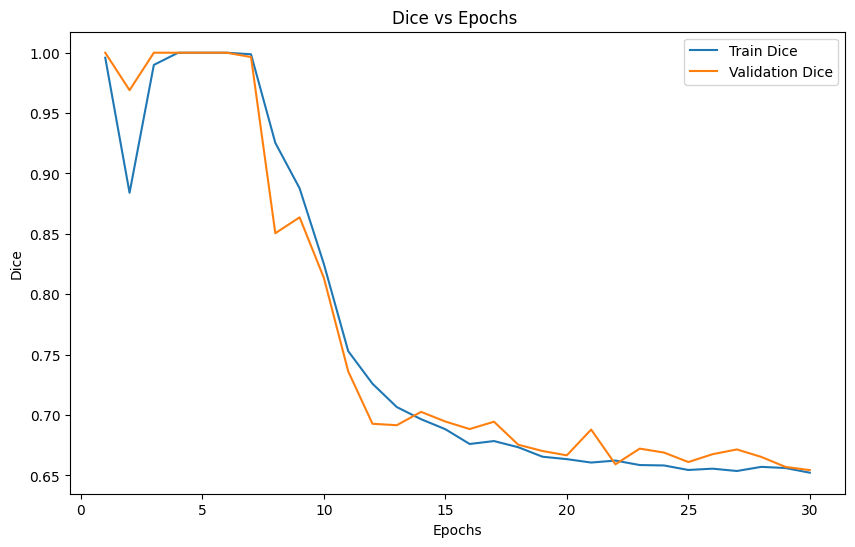

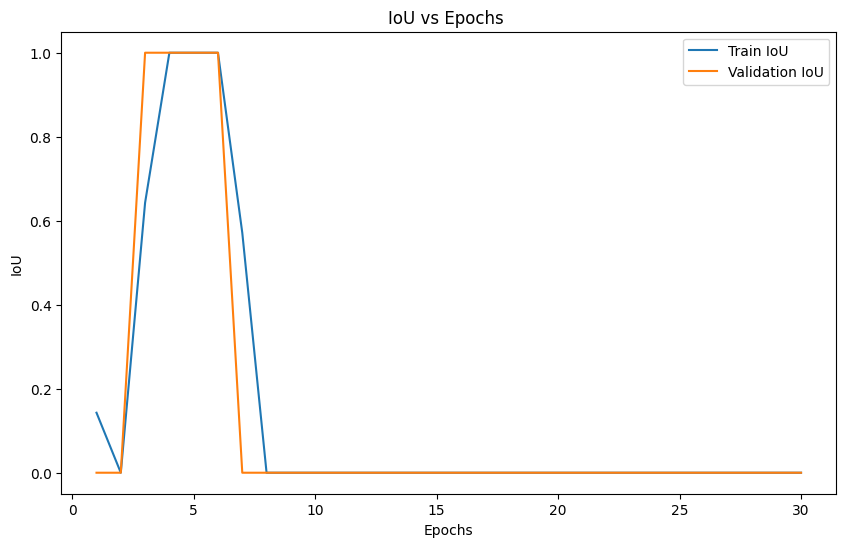

Testing the model


<ipython-input-11-4cda21ad89c0>:64: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(model_path)  # This loads the entire model (architecture + weights)
<ipy

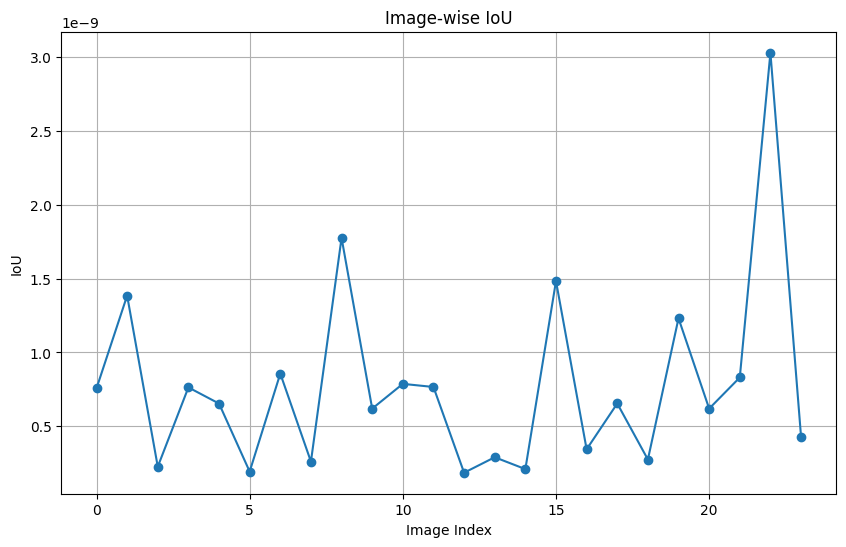

Average IoU on test set: 0.0000
Testing completed. Average IoU: 0.0000


In [ ]:
def main():
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    # Your existing dataset setup
    high_arsenic_dataset = AnnotatedSegmentationDataset(
            pml_dir='/content/drive/MyDrive/input/pml_high_arsenic_input',
            nuclei_dir='/content/drive/MyDrive/input/binary_mask_nucleus_high_arsenic_input',
            mask_dir='/content/drive/MyDrive/input/High_Arsenic_masks'
    )

    no_arsenic_dataset = AnnotatedSegmentationDataset(
            pml_dir='/content/drive/MyDrive/input/pml_no_arsenic_input',
            nuclei_dir='/content/drive/MyDrive/input/binary_mask_nucleus_non_arsenic_input',
            mask_dir='/content/drive/MyDrive/input/non_Arsenic_masks'
    )
    total_samples = len(high_arsenic_dataset) + len(no_arsenic_dataset)
    if total_samples == 0:
        raise ValueError("No valid samples found in either dataset!")

    print(f"\nTotal samples: {total_samples}")
    print(f"High arsenic samples: {len(high_arsenic_dataset)}")
    print(f"No arsenic samples: {len(no_arsenic_dataset)}")

    # Combine datasets
    dataset = ConcatDataset([high_arsenic_dataset, no_arsenic_dataset])
    print("Dataset is ready..")
    print("Visualizing dataset samples")

    train_ratio = 0.7  # 70% of the dataset for training
    val_ratio = 0.15   # 15% of the dataset for validation
    test_ratio = 0.15  # 15% of the dataset for testing

    train_size = int(train_ratio * total_samples)
    val_size = int(val_ratio * total_samples)
    test_size = total_samples - train_size - val_size  # Ensure the sizes sum up to total_size

    # Create the splits
    train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])
    visualize_dataset_samples(val_dataset)
    # Create DataLoaders for each split
    train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

    # Print some information about the splits
    print(f"Total dataset size: {total_samples}")
    print(f"Train size: {train_size}, Validation size: {val_size}, Test size: {test_size}")
    print("Data Loaded...")

    model = UNet(in_channels=3, out_channels=3, dropout_rate=0.4).to(device)
    metrics, metrics_summary = train_with_metrics(model, train_loader, val_loader, device=device, num_epochs=30, lr=0.001, save_path='/content/drive/MyDrive/output_unet_complex/modelunetcomplextrained')

    save_predictions(model, val_loader, device, output_base_dir='/content/drive/MyDrive/output_unet_complex/prediction_images')

    plot_metrics(metrics)

    print("Testing the model")
    model = UNet(in_channels=3, out_channels=3)

    # Define the path to the saved model
    model_path = "/content/drive/MyDrive/output_unet_complex/modelunetcomplextrained_model.pth"

    # testing model
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = torch.load(model_path)  # This loads the entire model (architecture + weights)
    model.load_state_dict(torch.load("/content/drive/MyDrive/output_unet_complex/modelunetcomplextrained_weights.pth"))
    model.to(device)

    test_stats = test_model(model, test_loader, device, output_dir="/content/drive/MyDrive/output_unet_complex/test_output")
    print(f"Testing completed. \nAverage IoU: {test_stats['avg_iou']:.4f}",
          f"Standard Deviation: {test_stats['std_dev']:.4f}",
          f"Number of Samples: {test_stats['num_samples']}",
        f"Minimum IoU: {test_stats['min_iou']:.4f}",
        f"Maximum IoU: {test_stats['max_iou']:.4f}")



if __name__ == "__main__":
    main()

# Trash Code

In [ ]:
# def train(model, train_loader, val_loader, device, num_epochs, lr):
#     optimizer = optim.Adam(model.parameters(), lr=lr)
#     criterion = nn.BCEWithLogitsLoss()  # Use for multi-channel masks with per-pixel binary classification.
#     print("Initiating training in epochs...")

#     for epoch in range(num_epochs):
#         model.train()
#         train_loss = 0
#         train_correct = 0
#         train_total = 0
#         print("Epoch : ", epoch)

#         # Training Loop
#         for inputs, masks in train_loader:
#             inputs = inputs.to(device)  # Inputs: [batch_size, 3, H, W]
#             masks = masks.to(device).float()  # Masks: [batch_size, 3, H, W], convert to float for BCEWithLogitsLoss

#             optimizer.zero_grad()
#             outputs = model(inputs)  # Outputs: [batch_size, 3, H, W]
#             loss = criterion(outputs, masks)
#             loss.backward()
#             optimizer.step()

#             train_loss += loss.item()

#             # Calculate per-pixel accuracy
#             preds = torch.sigmoid(outputs) > 0.5  # Convert logits to binary predictions
#             train_correct += (preds == masks).sum().item()
#             train_total += masks.numel()  # Total number of pixels across all channels

#         train_loss /= len(train_loader)
#         train_accuracy = 100 * train_correct / train_total

#         # Validation Loop
#         model.eval()
#         val_loss = 0
#         val_correct = 0
#         val_total = 0
#         with torch.no_grad():
#             for inputs, masks in val_loader:
#                 inputs = inputs.to(device)
#                 masks = masks.to(device).float()
#                 outputs = model(inputs)
#                 loss = criterion(outputs, masks)
#                 val_loss += loss.item()

#                 # Calculate per-pixel accuracy
#                 preds = torch.sigmoid(outputs) > 0.5
#                 val_correct += (preds == masks).sum().item()
#                 val_total += masks.numel()

#         val_loss /= len(val_loader)
#         val_accuracy = 100 * val_correct / val_total

#         print(f"Epoch [{epoch+1}/{num_epochs}], "
#               f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, "
#               f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

#     return model


# def main():
#     device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#     print(device)
#     high_arsenic_dataset = AnnotatedSegmentationDataset(
    #         pml_dir='E:/MLOps/Project/Images from Dellaire Lab/TIFF SAEC rep1 63x As high/pml_high_arsenic_input',
    #         nuclei_dir='E:/MLOps/Project/Images from Dellaire Lab/TIFF SAEC rep1 63x As high/binary_mask_nucleus_high_arsenic_input',
    #         mask_dir='E:/MLOps/Project/input/annotations/High_Arsenic_masks'
    # )

    # no_arsenic_dataset = AnnotatedSegmentationDataset(
    #         pml_dir='E:/MLOps/Project/Images from Dellaire Lab/TIFF SAEC rep1 63X no As/pml_no_arsenic_input',
    #         nuclei_dir='E:/MLOps/Project/Images from Dellaire Lab/TIFF SAEC rep1 63X no As/binary_mask_nucleus_non_arsenic_input',
    #         mask_dir='E:/MLOps/Project/input/annotations/non_Arsenic_masks'
    # )
    # total_samples = len(high_arsenic_dataset) + len(no_arsenic_dataset)
    # if total_samples == 0:
    #     raise ValueError("No valid samples found in either dataset!")

    # print(f"\nTotal samples: {total_samples}")
    # print(f"High arsenic samples: {len(high_arsenic_dataset)}")
    # print(f"No arsenic samples: {len(no_arsenic_dataset)}")

    #     # Combine datasets
    # dataset = ConcatDataset([high_arsenic_dataset, no_arsenic_dataset])
#     #print(dataset[0])
#     print("Dataset is ready..")
#     #print("Visualizing dataset samples")
#     #visualize_dataset_samples(dataset)

#     train_size = int(0.8 * len(dataset))
#     val_size = len(dataset) - train_size
#     train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])
#     #visualize_dataset_samples(val_dataset)
#     #visualize_dataset_samples(train_dataset)
#     #print(train_dataset[0])
#     train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
#     val_loader = DataLoader(val_dataset, batch_size=8)
#     #visualize_dataset_samples(val_dataset)
#     print("Data Loaded...")

#     model = UNet(in_channels=3, out_channels=3).to(device)
#     print("Model Created...")
#     print("Training Initiated...")